# Testing batdetect2 pipeline features:

## **Working on features relevant to the use of this pipeline on recovered Audiomoth .wav recordings**

## 1) Figuring out our imports:

### a) Below are the imports pertaining to accessing data and metadata

In [42]:
from pathlib import Path
import exiftool

### b) Below are the imports pertaining to data manipulation

In [43]:
import numpy as np
import pandas as pd

### c) Below are the imports pertaining to data visualization

In [44]:
import matplotlib.pyplot as plt
from matplotlib import colors
import datetime as dt

### d) Below are the imports pertaining to the use of the MSDS pipeline

In [45]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

from src.cfg import get_config
from src.pipeline import pipeline
import src.batdt2_pipeline as batdetect2_pipeline

## 2) Initializing our required variables:

### a) Below we initialize our input/output directories and output pipeline csv name

In [46]:
dirpath = f"{Path.home()}/Documents/Research/Symposium/Recordings/recover-20220828/UBNA_010"

recover_folder = dirpath.split('/')[-2]
recover_date = recover_folder.split('-')[1]
audiomoth_folder = dirpath.split('/')[-1]
audiomoth_unit = audiomoth_folder.split('_')[-1]

save_dir = f'../output_dir/{recover_folder}/{audiomoth_folder}'
detfile_name = f'batdetect2_pipeline__{recover_folder}_{audiomoth_folder}'

[dirpath, save_dir, detfile_name]

['/Users/adityakrishna/Documents/Research/Symposium/Recordings/recover-20220828/UBNA_010',
 '../output_dir/recover-20220828/UBNA_010',
 'batdetect2_pipeline__recover-20220828_UBNA_010']

### b) Below we initialize our field records depending on what year our data is from to gather the site name

In [47]:
if str(dt.datetime.strptime(recover_date, "%Y%m%d").year) == "2022":
    field_records = batdetect2_pipeline.get_field_records(Path(f"{Path.home()}/bat-detector-msds/notebooks/ubna_2022b.csv"))
if str(dt.datetime.strptime(recover_date, "%Y%m%d").year) == "2023":
    field_records = batdetect2_pipeline.get_field_records(Path(f"{Path.home()}/bat-detector-msds/notebooks/ubna_2023.csv"))

site_name = batdetect2_pipeline.get_site_name(field_records, recover_date, audiomoth_unit)
site_name

'Central Pond'

## 3) Test any main pipeline functions using the initialized variables

### a) Below we test-run our pipeline using the main `run_pipeline()` command in `src/batdt2_pipeline.py`

In [48]:
## Each file in directory has own set of detections from 0 to file_length
## Audio file corresponding to any detection is stored in .csv output's 'input_file' column

# batdetect2_pipeline.run_pipeline(dirpath, f"{detfile_name}.csv", save_dir, f'../output/tmp')

### b) Below is the function that will be used in our pipeline to plot the activity plots; Use it to test the overall function

In [49]:
# batdetect2_pipeline.plot_dets_as_activity_grid(dirpath, f"{detfile_name}.csv", save_dir, site_name, show_PST=True, save=False)

## 4) Develop any of the main functions below:

### a) Below is the code for plotting activity; it has been developed to include:

- PST functionality with axis labels for UTC/PST
- Plotting site name in title of activity
- Aligning ticks and grid lines to feel intuitive

[[   0.]
 [ 418.]
 [ 677.]
 [4900.]
 [1367.]
 [3178.]
 [3670.]
 [2631.]
 [1597.]
 [1060.]
 [ 638.]
 [ 897.]
 [  51.]
 [2534.]
 [6988.]
 [  57.]
 [ 116.]
 [  94.]
 [  13.]
 [   0.]
 [   0.]]


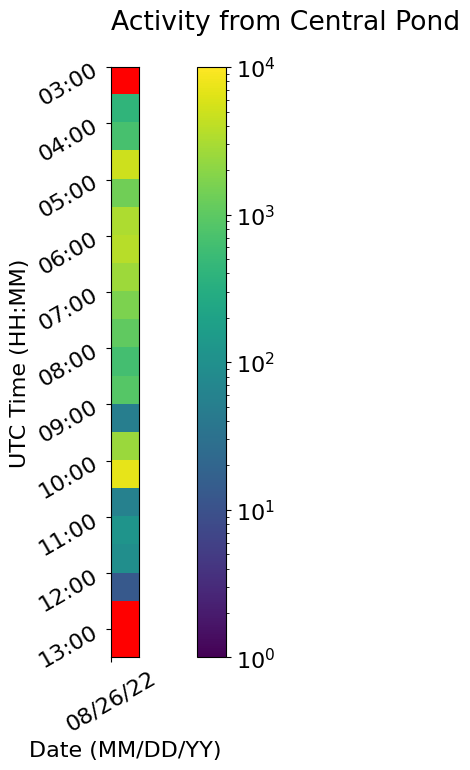

In [97]:
recover_folder = dirpath.split('/')[-2]
audiomoth_folder = dirpath.split('/')[-1]
dets = pd.read_csv(f'{save_dir}/{detfile_name}.csv')
activity = np.array([])
show_PST = False
activity_times = []
activity_dates = []

for file in batdetect2_pipeline.get_files_from_dir(dirpath):
    filedets = dets.loc[dets['input_file']==Path(file).name]
    activity = np.hstack([activity, len(filedets)])

    file_dt_UTC = dt.datetime.strptime(Path(file).name, "%Y%m%d_%H%M%S.WAV")

    if show_PST:
        if (file_dt_UTC.hour >= 7):
            file_dt_PST = dt.datetime.strptime(f"{file_dt_UTC.date()}_{str(file_dt_UTC.hour - 7).zfill(2)}{file_dt_UTC.minute}", "%Y-%m-%d_%H%M")
            file_time_PST = dt.datetime.strftime(file_dt_PST, "%H:%M")
        else:
            file_dt_PST = dt.datetime.strptime(f"{file_dt_UTC.date()}_{str(24 + file_dt_UTC.hour - 7).zfill(2)}{file_dt_UTC.minute}", "%Y-%m-%d_%H%M")
            file_time_PST = dt.datetime.strftime(file_dt_PST, "%H:%M")
        if (not(activity_times.__contains__(file_time_PST))):
            activity_times.append(file_time_PST)
    else:
        file_time_UTC = dt.datetime.strftime(file_dt_UTC, "%H:%M")
        if (not(activity_times.__contains__(file_time_UTC))):
            activity_times.append(file_time_UTC)

    file_date = dt.datetime.strftime(file_dt_UTC, "%m/%d/%y")
    if (not(activity_dates.__contains__(file_date))):
        activity_dates.append(file_date)

activity = activity.reshape((len(activity_dates), len(activity_times))).T

masked_array_for_nodets = np.ma.masked_where(activity == 0, activity)
cmap = plt.get_cmap('viridis')
cmap.set_bad(color='red', alpha=1.0)

print(activity)

plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(12, 8))
plt.title(f"Activity from {site_name}", loc='left', y=1.05)
plt.imshow(masked_array_for_nodets, cmap=cmap, norm=colors.LogNorm(vmin=1, vmax=10e3))
plt.yticks(np.arange(0, len(activity_times), 2)-0.5, activity_times[::2], rotation=30)
plt.xticks(np.arange(0, len(activity_dates))-0.5, activity_dates, rotation=30)
plt.ylabel('UTC Time (HH:MM)')
plt.xlabel('Date (MM/DD/YY)')
plt.colorbar()
plt.tight_layout()
plt.show()

### b) Below is the code for using exiftool to skip error files in our pipeline

- Starting to learn how to use exiftool or PyExifTool 
- Implementing checks for error files using Audiomoth .wav metadata
- Incorporating checks into generate_segments() function so pipeline only generates segments for valid recordings

#### Initialize the set of test files we need to analyze

- Some of them will be error files
- Some of them will be usable files

In [10]:
dirpath = f"{Path.home()}/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001"
files = batdetect2_pipeline.get_files_from_dir(dirpath)
files

[PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_030000.WAV'),
 PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_053000.WAV'),
 PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_060000.WAV'),
 PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_063000.WAV'),
 PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_090000.WAV')]

#### Print the metadata of a single Audiomoth recording

In [13]:
exiftool.ExifToolHelper().get_metadata(files)[4]

{'SourceFile': '/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_090000.WAV',
 'ExifTool:ExifToolVersion': 12.63,
 'File:FileName': '20230610_090000.WAV',
 'File:Directory': '/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001',
 'File:FileSize': 689280488,
 'File:FileModifyDate': '2023:06:10 14:59:54+05:30',
 'File:FileAccessDate': '2023:06:23 19:09:22+05:30',
 'File:FileInodeChangeDate': '2023:06:23 19:09:22+05:30',
 'File:FilePermissions': 100644,
 'File:FileType': 'WAV',
 'File:FileTypeExtension': 'WAV',
 'File:MIMEType': 'audio/x-wav',
 'RIFF:Encoding': 1,
 'RIFF:NumChannels': 1,
 'RIFF:SampleRate': 192000,
 'RIFF:AvgBytesPerSec': 384000,
 'RIFF:BitsPerSample': 16,
 'RIFF:Comment': 'Recorded at 09:00:00 10/06/2023 (UTC) by AudioMoth 24F319055FDF2F5B at medium gain while battery was 4.0V and temperature was 13.9C.',
 'RIFF:Artist': 'AudioMoth 24F319055FD

The RIFF:Comment tag seems important and unique to each error file.

- 488-byte ones say the recording was stopped because of microphone change.
- Standard size ones with unusable data say the recording was made using an external microphone.
- Standard size ones with usuable data have no mention of a microphone.

#### So let's look for NO mention of a "mircophone" in the RIFF:Comment and filter our files based on this.

In [40]:
good_files=[]
for file in files:
    comments = exiftool.ExifToolHelper().get_tags(file, tags='RIFF:Comment')
    if (not("microphone" in comments[0]['RIFF:Comment'])):
        good_files.append(Path(comments[0]['SourceFile']))

good_files
# 'RIFF:Comment'
# df_comments = pd.DataFrame(comments)
# good_files = df_comments.loc[~df_comments['RIFF:Comment'].str.contains("microphone")]['SourceFile'].values
# good_files

[PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_090000.WAV')]

#### Our filter worked and our pipeline ran on the good_files of `recover-20230616/UBNA_001` with no error

### Now we need to make changes in our plotting to plot data generated from error sessions

#### 1) Import `recover-20230616_UBNA_001 detections

In [29]:
dirpath = f"{Path.home()}/Documents/Research/Symposium/Recordings/recover-20230616/UBNA_001"

recover_folder = dirpath.split('/')[-2]
recover_date = recover_folder.split('-')[1]
audiomoth_folder = dirpath.split('/')[-1]
audiomoth_unit = audiomoth_folder.split('_')[-1]

save_dir = f'../output_dir/{recover_folder}/{audiomoth_folder}'
detfile_name = f'batdetect2_pipeline__{recover_folder}_{audiomoth_folder}'

[dirpath, save_dir, detfile_name]

dets = pd.read_csv(f'{save_dir}/{detfile_name}.csv')
det_times = []
for file in get_files_from_dir(dirpath):
    file_dt = dt.datetime.strptime(file.name, "%Y%m%d_%H%M%S.WAV")
    file_time = dt.datetime.strftime(file_dt, "%H%M%S")
    if (not(det_times.__contains__(file_time))):
        det_times.append(file_time)
print(sorted(det_times))



['030000',
 '043000',
 '050000',
 '053000',
 '060000',
 '063000',
 '070000',
 '073000',
 '080000',
 '083000',
 '090000',
 '093000',
 '100000',
 '103000',
 '110000',
 '130000']

In [ ]:
recover_folder = dirpath.split('/')[-2]
audiomoth_folder = dirpath.split('/')[-1]
dets = pd.read_csv(f'{save_dir}/{detfile_name}.csv')
activity = np.array([])
show_PST = False
activity_times = []
activity_dates = []

for file in batdetect2_pipeline.get_files_from_dir(dirpath):
    filedets = dets.loc[dets['input_file']==Path(file).name]
    activity = np.hstack([activity, len(filedets)])

    file_dt_UTC = dt.datetime.strptime(Path(file).name, "%Y%m%d_%H%M%S.WAV")

    if show_PST:
        if (file_dt_UTC.hour >= 7):
            file_dt_PST = dt.datetime.strptime(f"{file_dt_UTC.date()}_{str(file_dt_UTC.hour - 7).zfill(2)}{file_dt_UTC.minute}", "%Y-%m-%d_%H%M")
            file_time_PST = dt.datetime.strftime(file_dt_PST, "%H:%M")
        else:
            file_dt_PST = dt.datetime.strptime(f"{file_dt_UTC.date()}_{str(24 + file_dt_UTC.hour - 7).zfill(2)}{file_dt_UTC.minute}", "%Y-%m-%d_%H%M")
            file_time_PST = dt.datetime.strftime(file_dt_PST, "%H:%M")
        if (not(activity_times.__contains__(file_time_PST))):
            activity_times.append(file_time_PST)
    else:
        file_time_UTC = dt.datetime.strftime(file_dt_UTC, "%H:%M")
        if (not(activity_times.__contains__(file_time_UTC))):
            activity_times.append(file_time_UTC)

    file_date = dt.datetime.strftime(file_dt_UTC, "%m/%d/%y")
    if (not(activity_dates.__contains__(file_date))):
        activity_dates.append(file_date)

activity = activity.reshape((len(activity_dates), len(activity_times))).T

plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(12, 8))
plt.title(f"Activity from {site_name}", loc='left', y=1.05)
plt.imshow(activity+1, norm=colors.LogNorm(vmin=1, vmax=10e3))
plt.yticks(np.arange(0, len(activity_times), 2)-0.5, activity_times[::2], rotation=30)
plt.xticks(np.arange(0, len(activity_dates))-0.5, activity_dates, rotation=30)
plt.ylabel('UTC Time (HH:MM)')
plt.xlabel('Date (MM/DD/YY)')
plt.colorbar()
plt.tight_layout()
plt.show()